            retail_sales
1992-01-01        1130.0
1992-02-01        1288.0
1992-03-01        1409.0
1992-04-01        1684.0
1992-05-01        1408.0
...                  ...
2023-09-01       12308.0
2023-10-01       11929.0
2023-11-01       10710.0
2023-12-01        9995.0
2024-01-01       10522.0

[385 rows x 1 columns]


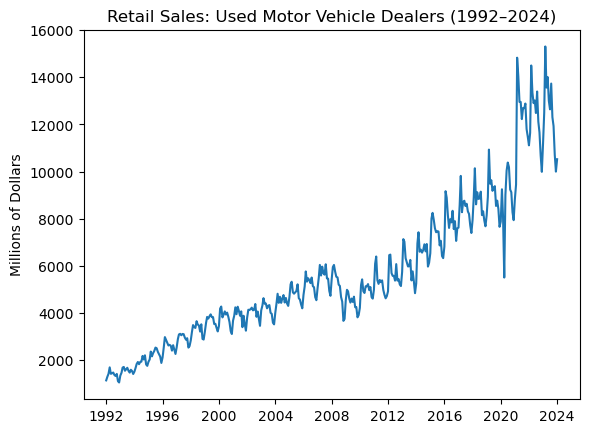

In [15]:
from fredapi import Fred
import pandas as pd
import numpy as np

# Replace 'your_api_key' with your actual FRED API key
fred = Fred(api_key='e7d91fd4ac05e8ae87fa956d551f861f')

data = fred.get_series("MRTSSM44112USN", observation_start="1992-01-01", observation_end="2024-01-01")

df = pd.DataFrame(data, columns=["retail_sales"])
df.index = pd.to_datetime(df.index)
print(df)

import matplotlib.pyplot as plt

plt.plot(df, label="Retail Sales Used Cars")
plt.title("Retail Sales: Used Motor Vehicle Dealers (1992–2024)")
plt.ylabel("Millions of Dollars")
plt.show()

In [16]:
# Estimate a linear trend 
from statsmodels.api import OLS
from statsmodels.tools import add_constant

# Add a constant term to the independent variable
t = range(len(df)) 
X = pd.DataFrame({'t': t}, index=df.index)
X = add_constant(X)  # Add a constant term for the intercept

# Fit a linear trend 
model = OLS(df, X)
results = model.fit()


# Estimate a quadratic trend
t_squared = [i**2 for i in t]  # Squared term

# Align indices by using df's index
X_quad = pd.DataFrame({'t': t, 't_squared': t_squared}, index=df.index)
X_quad = add_constant(X_quad)  # Add a constant term for the intercept

# Fit a quadratic trend model
model_quad = OLS(df, X_quad)  # Dependent variable is the column 'df'
results_quad = model_quad.fit()


# Create the first lag of the industrial production index
df['retail_sales_lag1'] = df['retail_sales'].shift(1)

# Drop the first row with NaN value due to lagging
df = df.dropna()

# Update the independent variables to include the lagged variable
X_with_lag = X.iloc[1:].copy()  # Exclude the first row to match the lagged data
X_with_lag['retail_sales_lag1'] = df['retail_sales_lag1']

# Fit the linear trend model with the lagged variable
model_with_lag = OLS(df, X_with_lag)
results_with_lag = model_with_lag.fit()

Text(0.5, 1.0, 'Residuals of Linear Trend Model with Lagged Variable')

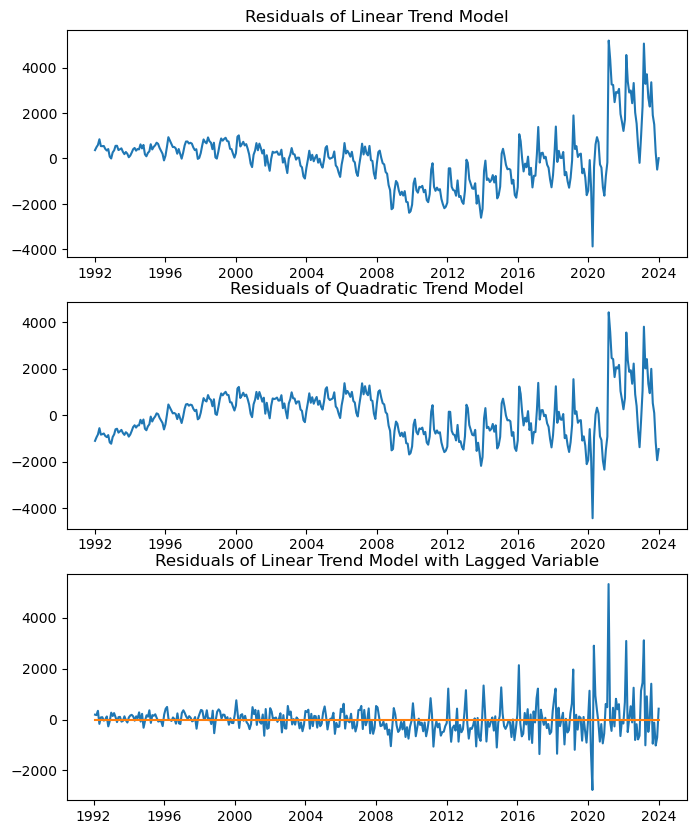

In [17]:
# Residual plots for the three models
plt.figure(figsize=(8, 10))
plt.subplot(3, 1, 1)
plt.plot(results.resid)
plt.title('Residuals of Linear Trend Model')
plt.subplot(3, 1, 2)
plt.plot(results_quad.resid)
plt.title('Residuals of Quadratic Trend Model')
plt.subplot(3, 1, 3)
plt.plot(results_with_lag.resid)
plt.title('Residuals of Linear Trend Model with Lagged Variable')

In [18]:
# Compare models using AIC and BIC
models = {
    'Linear Trend': results,
    'Quadratic Trend': results_quad,
    'Linear Trend with AR': results_with_lag
}

# Create a list to store the AIC and BIC values
comparison_data = []

for model_name, model_results in models.items():
    comparison_data.append({
        'Model': model_name,
        'AIC': model_results.aic,
        'BIC': model_results.bic
    })

# Convert the list of dictionaries to a DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Display the comparison DataFrame
print(comparison_df)

                  Model          AIC          BIC
0          Linear Trend  6550.028022  6557.934509
1       Quadratic Trend  6411.496617  6423.356347
2  Linear Trend with AR  6043.423739  6055.275666


In [21]:
df["post2008"] = (df.index >= "2008-01-01").astype(int)

X_break = X_with_lag.copy()
X_break['post2008'] = df['post2008']

model_break = OLS(df["retail_sales"], X_break)
results_break = model_break.fit()
print(results_break.summary())

                            OLS Regression Results                            
Dep. Variable:           retail_sales   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     2922.
Date:                Fri, 30 Jan 2026   Prob (F-statistic):          5.02e-262
Time:                        01:40:45   Log-Likelihood:                -3015.8
No. Observations:                 384   AIC:                             6040.
Df Residuals:                     380   BIC:                             6055.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                69.8805     71.85

C:\Users\Jung Jae Kim\AppData\Local\Temp\ipykernel_54820\1998825474.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["post2008"] = (df.index >= "2008-01-01").astype(int)


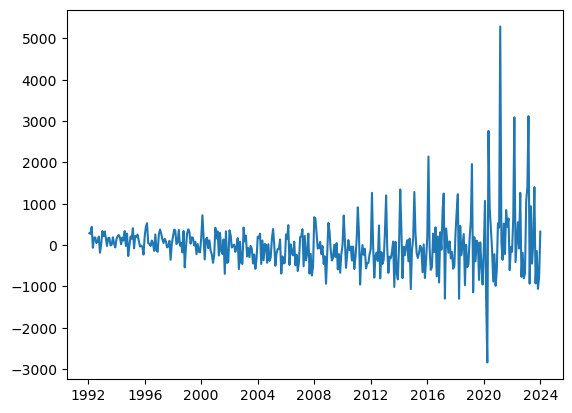

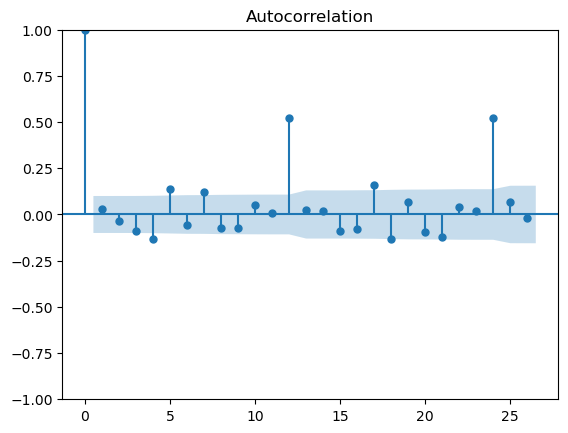

In [22]:
# Residuals plot and the correlogram of the detrended data
from statsmodels.graphics.tsaplots import plot_acf

plt.plot(results_break.resid)
plot_acf(results_break.resid)
plt.show()

In [23]:
df["covid"] = ((df.index >= "2020-03-01") & (df.index <= "2021-12-01")).astype(int)

X_covid = X_break.copy()
X_covid['covid'] = df['covid']

model_covid = OLS(df["retail_sales"], X_covid)
results_covid = model_covid.fit()
print(results_covid.summary())

                            OLS Regression Results                            
Dep. Variable:           retail_sales   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     2205.
Date:                Fri, 30 Jan 2026   Prob (F-statistic):          5.85e-261
Time:                        01:41:20   Log-Likelihood:                -3014.2
No. Observations:                 384   AIC:                             6038.
Df Residuals:                     379   BIC:                             6058.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               101.3475     73.74

C:\Users\Jung Jae Kim\AppData\Local\Temp\ipykernel_54820\2124631969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["covid"] = ((df.index >= "2020-03-01") & (df.index <= "2021-12-01")).astype(int)


In [24]:
# Generate seasonal dummies
df['Q1'] = df.index.month.isin([1, 2, 3]).astype(int)
df['Q2'] = df.index.month.isin([4, 5, 6]).astype(int)
df['Q3'] = df.index.month.isin([7, 8, 9]).astype(int)
df['Q4'] = df.index.month.isin([10, 11, 12]).astype(int)

X_seasonal = X_with_lag.copy()
X_seasonal['Q1'] = df['Q1']
X_seasonal['Q2'] = df['Q2']
X_seasonal['Q3'] = df['Q3']

model_seasonal = OLS(df["retail_sales"], X_seasonal)
results_seasonal = model_seasonal.fit()
print(results_seasonal.summary())


                            OLS Regression Results                            
Dep. Variable:           retail_sales   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     2265.
Date:                Fri, 30 Jan 2026   Prob (F-statistic):          3.19e-279
Time:                        01:41:29   Log-Likelihood:                -2967.5
No. Observations:                 384   AIC:                             5947.
Df Residuals:                     378   BIC:                             5971.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -156.4784     76.06

C:\Users\Jung Jae Kim\AppData\Local\Temp\ipykernel_54820\902454862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Q1'] = df.index.month.isin([1, 2, 3]).astype(int)
C:\Users\Jung Jae Kim\AppData\Local\Temp\ipykernel_54820\902454862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Q2'] = df.index.month.isin([4, 5, 6]).astype(int)
C:\Users\Jung Jae Kim\AppData\Local\Temp\ipykernel_54820\902454862.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

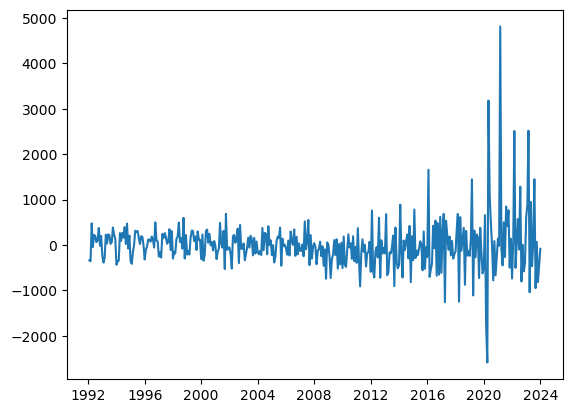

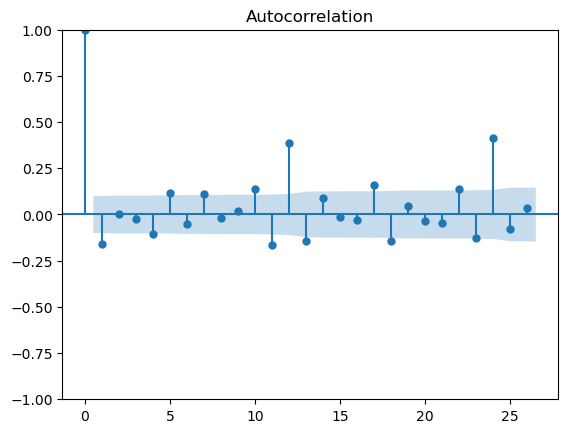

In [25]:
# Plot the residuals and correlogram
plt.plot(results_seasonal.resid)
plot_acf(results_seasonal.resid)
plt.show()